<a href="https://colab.research.google.com/github/hridyamunjal/BERT-Text-Classifier-TPU/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#install the neccesary libraries

!pip install transformers

In [2]:
import tensorflow as tf
import logging
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv1D,
    Dropout,
    Input,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from transformers import BertTokenizer, TFBertModel
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas()
import re
import random

In [3]:
#Checking and initializing the TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:                                  #if no TPU Available, code shifts to GPU or CPU
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [4]:
max_length = 140
batch_size = 16
dev_size = 0.1
num_class = 4

model_name = "bert-base-multilingual-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [6]:
train_df = pd.read_csv('database/Arabizi-Dailect-Train.csv')

train_df.text = train_df.text.astype(str)
train_df.drop_duplicates(subset=['text'],inplace=True)
train_df.label=train_df.label.map({-1:0,1:2,0:1})
train, dev = train_test_split(train_df, test_size=dev_size, random_state=42)

In [7]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(
        data, max_length=max_length, padding="max_length", truncation=True
    )
    return tf.constant(tokens["input_ids"])
train_encoded = bert_encode(train.text)
dev_encoded = bert_encode(dev.text)
train_labels = tf.keras.utils.to_categorical(train.label.values, num_classes=num_class)
dev_labels = tf.keras.utils.to_categorical(dev.label.values, num_classes=num_class)
train_dataset = (
    tf.data.Dataset.from_tensor_slices((train_encoded, train_labels))
    .shuffle(100)
    .batch(batch_size)
).cache()
dev_dataset = (
    tf.data.Dataset.from_tensor_slices((dev_encoded, dev_labels))
    .shuffle(100)
    .batch(batch_size)
).cache()

In [8]:
def bert_tweets_model():
    bert_encoder = TFBertModel.from_pretrained("bert-base-multilingual-uncased", output_attentions=True)
    input_word_ids = Input(
        shape=(max_length,), dtype=tf.int32, name="input_ids"
    )
    last_hidden_states = bert_encoder(input_word_ids)[0]
    clf_output = Flatten()(last_hidden_states)
    net = Dense(512, activation="relu")(clf_output)
    net = Dropout(0.3)(net)
    net = Dense(440, activation="relu")(net)
    net = Dropout(0.3)(net)
    output = Dense(num_class, activation="softplus")(net)
    model = Model(inputs=input_word_ids, outputs=output)
    return model

In [12]:
with strategy.scope():
    model = bert_tweets_model()
    adam_optimizer = Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)  # Adjust the loss function accordingly
    model.compile(loss=loss, optimizer=adam_optimizer, metrics=["accuracy"])
    model.summary()

    # the error message is not a cause for concern, especially if your primary goal is to use the model for a similar task.
    #Just ensure that your TensorFlow model is working correctly and producing the expected results for your specific use case.

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 140)]             0         
                                                                 
 tf_bert_model_1 (TFBertMode  TFBaseModelOutputWithPoo  167356416
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             140, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=((None, 12, None,             
                             140),                               
                              (None, 12, None, 140),       

In [10]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=5,
    validation_data=dev_dataset,
    verbose=1,
)

#The time taken for each epoch should be around 500-600s, if it takes more than that make sure you've changed the Runtime from CPU to TPU

Epoch 1/5


4166/4166 [==============================] - 522s 105ms/step - loss: 0.6538 - accuracy: 0.7156 - val_loss: 0.5243 - val_accuracy: 0.7725
Epoch 2/5
4166/4166 [==============================] - 436s 105ms/step - loss: 0.4887 - accuracy: 0.7966 - val_loss: 0.4957 - val_accuracy: 0.8027
Epoch 3/5
4166/4166 [==============================] - 427s 102ms/step - loss: 0.3978 - accuracy: 0.8396 - val_loss: 0.5221 - val_accuracy: 0.8072
Epoch 4/5
4166/4166 [==============================] - 442s 106ms/step - loss: 0.3081 - accuracy: 0.8779 - val_loss: 0.5930 - val_accuracy: 0.8078
Epoch 5/5
4166/4166 [==============================] - 425s 102ms/step - loss: 0.2352 - accuracy: 0.9096 - val_loss: 0.6194 - val_accuracy: 0.8151


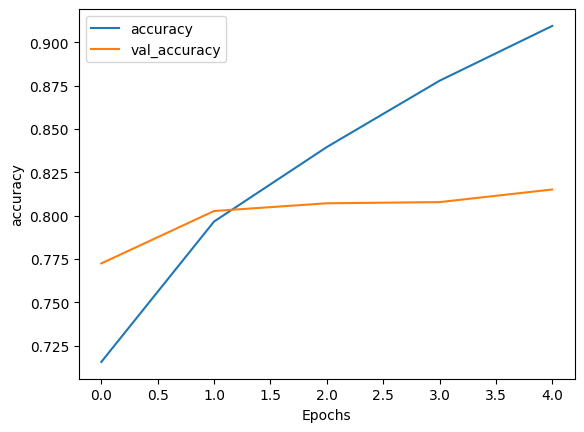

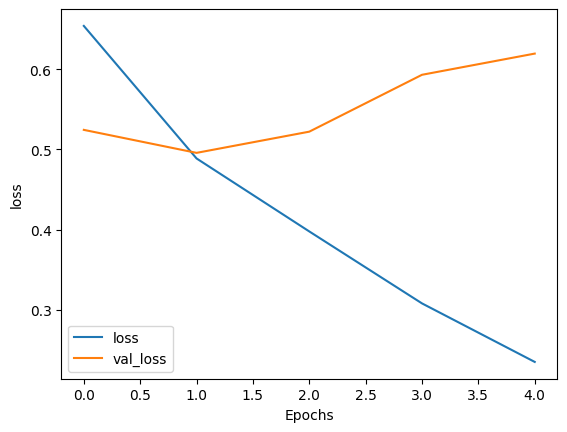

In [11]:
#visualising accuracy and loss
import matplotlib.pyplot as plt
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history["val_" + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, "val_" + string])
    plt.show()
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [11]:
test = pd.read_csv("database/Arabizi-Dailect-Train.csv/Test (1).csv")
test.text = test.text.astype(str)
test_encoded = bert_encode(test.text)
##Loading Test Data
test_dataset = tf.data.Dataset.from_tensor_slices(test_encoded).batch(batch_size)
## Prediction on test Datasets
predicted_tweets = model.predict(test_dataset, batch_size=batch_size)
predicted_tweets_binary = np.argmax(predicted_tweets, axis=-1)